## Load and prep columns

In [1]:
import xgboost as xgb
import numpy as np
import pandas as pd
from xgboost.sklearn import XGBRegressor
from xgboost import plot_importance
from matplotlib import pyplot
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from scipy import stats

%config InlineBackend.figure_format = 'retina'

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)


# Define columns
data_columns = ['symbol', 'quoteDate', 'adjustedPrice', 'volume', 'previousClose', 'change', 'changeInPercent', 
                '52WeekHigh', '52WeekLow', 'changeFrom52WeekHigh', 'changeFrom52WeekLow', 
                'percebtChangeFrom52WeekHigh', 'percentChangeFrom52WeekLow', 'Price200DayAverage', 
                'Price52WeekPercChange', '1WeekVolatility', '2WeekVolatility', '4WeekVolatility', '8WeekVolatility', 
                '12WeekVolatility', '26WeekVolatility','52WeekVolatility','4WeekBollingerPrediction', '4WeekBollingerType',
                '12WeekBollingerPrediction', '12WeekBollingerType', 'allordpreviousclose', 'allordchange', 
                'allorddayshigh', 'allorddayslow', 'allordpercebtChangeFrom52WeekHigh', 
                'allordpercentChangeFrom52WeekLow', 'asxpreviousclose', 'asxchange', 'asxdayshigh', 
                'asxdayslow', 'asxpercebtChangeFrom52WeekHigh', 'asxpercentChangeFrom52WeekLow', 'exDividendDate', 
                'exDividendPayout', '640106_A3597525W', 'AINTCOV', 'AverageVolume', 'BookValuePerShareYear', 
                'CashPerShareYear', 'DPSRecentYear', 'EBITDMargin', 'EPS', 'EPSGrowthRate10Years', 
                'EPSGrowthRate5Years', 'FIRMMCRT', 'FXRUSD', 'Float', 'GRCPAIAD', 'GRCPAISAD', 'GRCPBCAD', 
                'GRCPBCSAD', 'GRCPBMAD', 'GRCPNRAD', 'GRCPRCAD', 'H01_GGDPCVGDP', 'H01_GGDPCVGDPFY', 'H05_GLFSEPTPOP', 
                'IAD', 'LTDebtToEquityQuarter', 'LTDebtToEquityYear', 'MarketCap',
                'NetIncomeGrowthRate5Years', 'NetProfitMarginPercent', 'OperatingMargin', 'PE',
                'PriceToBook', 'ReturnOnAssets5Years', 'ReturnOnAssetsTTM', 'ReturnOnAssetsYear', 
                'ReturnOnEquity5Years', 'ReturnOnEquityTTM', 'ReturnOnEquityYear', 'RevenueGrowthRate10Years', 
                'RevenueGrowthRate5Years', 'TotalDebtToAssetsQuarter', 'TotalDebtToAssetsYear', 
                'TotalDebtToEquityQuarter', 'TotalDebtToEquityYear', 'bookValue', 'earningsPerShare', 
                'ebitda', 'epsEstimateCurrentYear', 'marketCapitalization', 'peRatio', 'pegRatio', 'pricePerBook', 
                'pricePerEpsEstimateCurrentYear', 'pricePerEpsEstimateNextYear', 'pricePerSales']

returns = {
    '1': 'Future1WeekReturn',
    '2': 'Future2WeekReturn',
    '4': 'Future4WeekReturn',
    '8': 'Future8WeekReturn',
    '12': 'Future12WeekReturn',
    '26': 'Future26WeekReturn',
    '52': 'Future52WeekReturn',
    '1ra': 'Future1WeekRiskAdjustedReturn',
    '2ra': 'Future2WeekRiskAdjustedReturn',
    '4ra': 'Future4WeekRiskAdjustedReturn',
    '8ra': 'Future8WeekRiskAdjustedReturn',
    '12ra': 'Future12WeekRiskAdjustedReturn',
    '26ra': 'Future26WeekRiskAdjustedReturn',
    '52ra': 'Future52WeekRiskAdjustedReturn'
}

# Load data
raw_data = pd.read_csv('data/companyQuotes-20170417-001.csv')
raw_data.head(5)

/Users/neilkloot/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/neilkloot/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (45) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,symbol,quoteDate,lastTradePriceOnly,adjustedPrice,volume,daysHigh,daysLow,previousClose,change,changeInPercent,52WeekHigh,52WeekLow,changeFrom52WeekHigh,changeFrom52WeekLow,percebtChangeFrom52WeekHigh,percentChangeFrom52WeekLow,Price200DayAverage,Price52WeekPercChange,1WeekVolatility,2WeekVolatility,4WeekVolatility,8WeekVolatility,12WeekVolatility,26WeekVolatility,52WeekVolatility,4WeekBollingerBandLower,4WeekBollingerBandUpper,4WeekBollingerPrediction,4WeekBollingerType,12WeekBollingerBandLower,12WeekBollingerBandUpper,12WeekBollingerPrediction,12WeekBollingerType,allordpreviousclose,allordchange,allorddayshigh,allorddayslow,allordpercebtChangeFrom52WeekHigh,allordpercentChangeFrom52WeekLow,asxpreviousclose,asxchange,asxdayshigh,asxdayslow,asxpercebtChangeFrom52WeekHigh,asxpercentChangeFrom52WeekLow,exDividendDate,exDividendPayout,640106_A3597525W,AINTCOV,AverageVolume,Beta,BookValuePerShareYear,CashPerShareYear,DPSRecentYear,EBITDMargin,EPS,EPSGrowthRate10Years,EPSGrowthRate5Years,FIRMMCRT,FXRUSD,Float,GRCPAIAD,GRCPAISAD,GRCPBCAD,GRCPBCSAD,GRCPBMAD,GRCPNRAD,GRCPRCAD,H01_GGDPCVGDP,H01_GGDPCVGDPFY,H05_GLFSEPTPOP,IAD,LTDebtToEquityQuarter,LTDebtToEquityYear,MarketCap,NetIncomeGrowthRate5Years,NetProfitMarginPercent,OperatingMargin,PE,PriceToBook,QuoteLast,ReturnOnAssets5Years,ReturnOnAssetsTTM,ReturnOnAssetsYear,ReturnOnEquity5Years,ReturnOnEquityTTM,ReturnOnEquityYear,RevenueGrowthRate10Years,RevenueGrowthRate5Years,TotalDebtToAssetsQuarter,TotalDebtToAssetsYear,TotalDebtToEquityQuarter,TotalDebtToEquityYear,bookValue,earningsPerShare,ebitda,epsEstimateCurrentYear,marketCapitalization,peRatio,pegRatio,pricePerBook,pricePerEpsEstimateCurrentYear,pricePerEpsEstimateNextYear,pricePerSales,Future1WeekDividend,Future1WeekPrice,Future1WeekReturn,Future1WeekRiskAdjustedReturn,Future2WeekDividend,Future2WeekPrice,Future2WeekReturn,Future2WeekRiskAdjustedReturn,Future4WeekDividend,Future4WeekPrice,Future4WeekReturn,Future4WeekRiskAdjustedReturn,Future8WeekDividend,Future8WeekPrice,Future8WeekReturn,Future8WeekRiskAdjustedReturn,Future12WeekDividend,Future12WeekPrice,Future12WeekReturn,Future12WeekRiskAdjustedReturn,Future26WeekDividend,Future26WeekPrice,Future26WeekReturn,Future26WeekRiskAdjustedReturn,Future52WeekDividend,Future52WeekPrice,Future52WeekReturn,Future52WeekRiskAdjustedReturn
0,CCA,2016-06-30,0.560,0.560,1876700,0.770,0.535,0.765,-0.205,-0.267974,0.56,0.560,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.560000,0.560000,Steady,Within,0.560000,0.560000,Steady,Within,5221.000000,41.299805,5324.399902,5221.000000,-0.082183,0.083960,5142.399902,39.100097,5247.600098,5142.399902,-0.098884,0.079135,NaN,NaN,108.2,3828.0,NaN,NaN,0.24,-0.213,NaN,NaN,-30.8,NaN,NaN,1.77,0.7426,63500000.0,87.307409,89.957900,87.425456,92.706255,87.037799,85.756318,96.070719,412937.0,1.227102,61.092677,NaN,NaN,NaN,36000000.0,NaN,NaN,-4147.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-67.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.55,-1.785714,-7.688946,NaN,0.65,16.071429,2.693578,NaN,0.64,14.285714,2.260607,NaN,0.61,8.928571,1.801456,NaN,0.54,-3.571429,-19.327464,NaN,0.56,NaN,NaN,NaN,NaN,NaN,NaN
1,CCA,2016-07-01,0.590,0.590,985000,0.625,0.500,0.515,0.075,0.145631,0.59,0.560,0.000,0.03,0.000000,0.053571,NaN,NaN,0.015000,0.015000,0.015000,0.015000,0.015000,0.015000,0.015000,0.545000,0.605000,Steady,Within,0.545000,0.605000,Steady,Within,5310.399902,89.399902,5356.500000,5310.399902,-0.066467,0.102520,5233.399902,91.000000,5278.899902,5233.399902,-0.082938,0.098231,NaN,NaN,108.2,3828.0,NaN,NaN,0.24,-0.213,0.0,NaN,-30.8,NaN,NaN,1.77,0.7460,63500000.0,87.307409,89.957900,87.425456,92.706255,87.037799,85.756318,96.070719,412937.0,1.227102,61.092677,NaN,NaN,NaN,36000000.0,NaN,NaN,-4147.2,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-67.4,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.54,-8.474576,-33.621753,0.0,0.65,10.169492,1.644524,0.0,0.67,13.559322,2.167481,0.0,0.60,1.694915,0.343165,0.0,0.52,-11.864407,-65.4875

In [2]:
# Clip values less than -99 (represents losing all money, can't go below -100)
for key in returns:
    return_column = returns[key]
    raw_data[return_column] = raw_data[return_column].clip(-99, 999, axis=0)

In [ ]:
# Plot values for each potential target
for key in returns:
    print('-----')
    return_column = returns[key]
    print(return_column)
    raw_data.hist(column=return_column,bins=[-50, -45, -40, -35, -30, -25, -20, -15, -10, -5, 0, 
                                            5, 10, 15, 20, 25, 30, 35, 40, 45, 50])
    pyplot.show()


    print('Instances: ', raw_data[return_column].count())
    print('Mean: ', raw_data[return_column].mean())
    print('Min: ', raw_data[return_column].min())
    print('25th percentile: ', raw_data[return_column].quantile(0.25))
    print('Median: ', raw_data[return_column].median())
    print('75th percentile: ', raw_data[return_column].quantile(0.75))
    print('Max: ', raw_data[return_column].max())
    print('Std deviation: ', raw_data[return_column].std())
    print('Variance: ', raw_data[return_column].var())
    print('Skew: ', raw_data[return_column].skew())

In [ ]:
# Check outliers
outliers = raw_data.loc[(raw_data[target_column] > 100) | (raw_data[target_column] < -50)]
print(len(outliers))

exclude_symbols = outliers['symbol'].unique()

In [ ]:
# Remove rows in the excluded symbols list
filtered_data = raw_data[~raw_data['symbol'].isin(exclude_symbols)]


## Apply filter for specific symbolx

In [35]:
# Run filter for a few companies
include_symbols = ['BHP', 'CBA', 'AOU', 'AYS', 'ATT', 'A01', 'BUD', 'AAP', 'AIV', 'AIB', '4DS']
reduced_data = raw_data[raw_data['symbol'].isin(include_symbols)]
print(len(reduced_data))

10423


In [36]:
filtered_data = reduced_data

-----
Future1WeekReturn


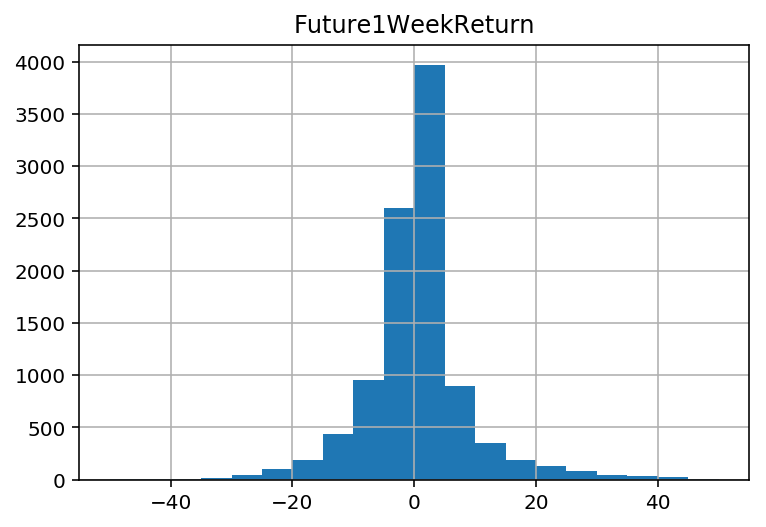

Instances:  10126
Mean:  0.7722747240919976
Min:  -80.0
25th percentile:  -3.1250000000000027
Median:  0.0
75th percentile:  3.2388402784491914
Max:  350.0
Std deviation:  11.840387877649798
Variance:  140.1947850931963
Skew:  8.28526214978
-----
Future2WeekReturn


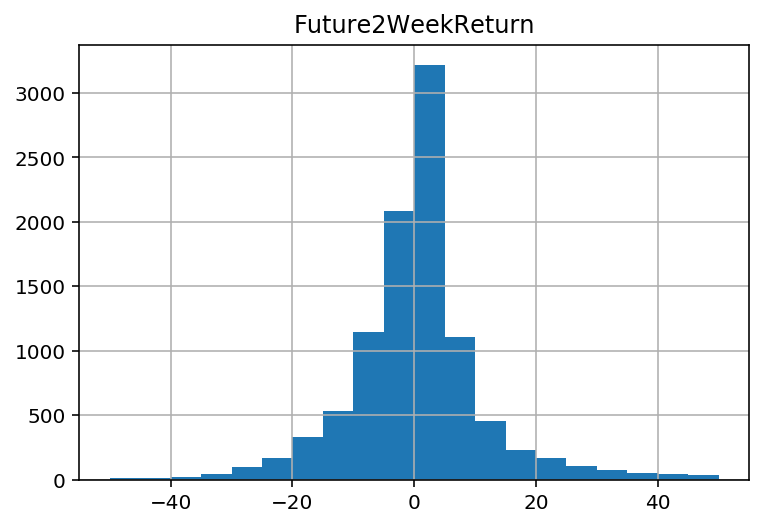

Instances:  10080
Mean:  1.559798166249274
Min:  -80.0
25th percentile:  -4.490026408773577
Median:  0.0
75th percentile:  4.704078173228206
Max:  733.333333333
Std deviation:  20.44788715956397
Variance:  418.116089290261
Skew:  13.2859874573
-----
Future4WeekReturn


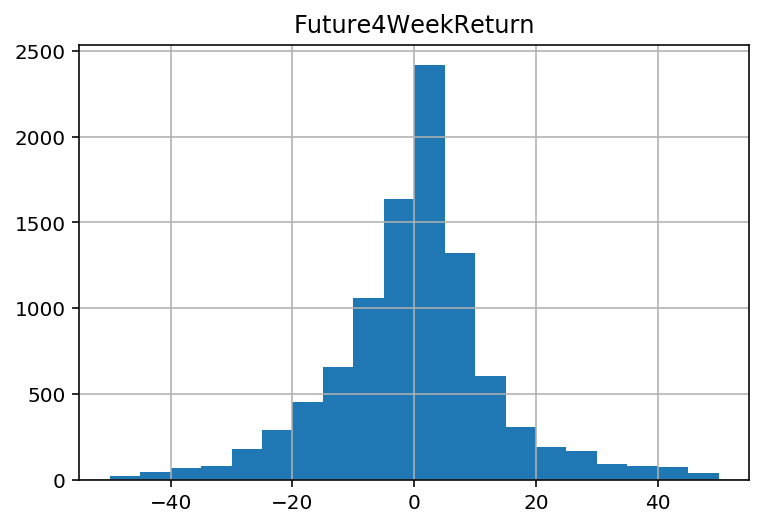

Instances:  10024
Mean:  2.552912463721559
Min:  -88.4210526316
25th percentile:  -6.356655864477369
Median:  0.10818602140284328
75th percentile:  6.772695392911099
Max:  999.0
Std deviation:  30.33375800439467
Variance:  920.1368746691778
Skew:  12.7003106911
-----
Future8WeekReturn


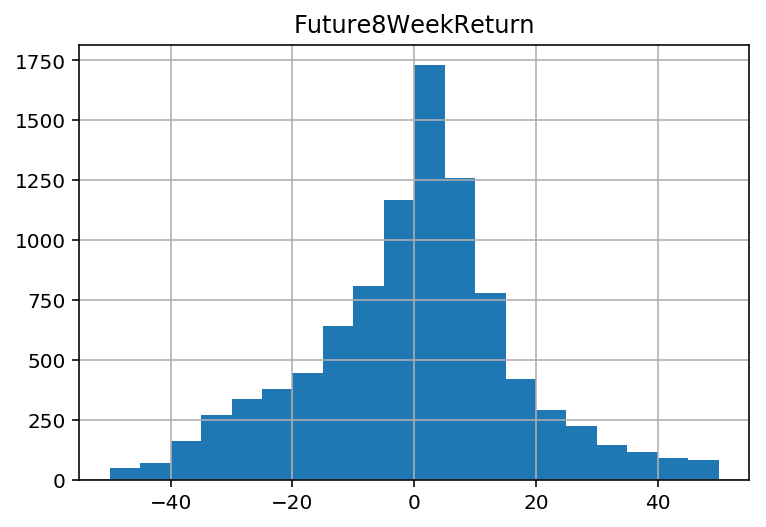

Instances:  9952
Mean:  4.541444559164721
Min:  -86.3157894737
25th percentile:  -9.661512692479802
Median:  1.1260950601437547
75th percentile:  10.249740083918445
Max:  999.0
Std deviation:  43.35312345411915
Variance:  1879.4933132280958
Skew:  9.80280930409
-----
Future12WeekReturn


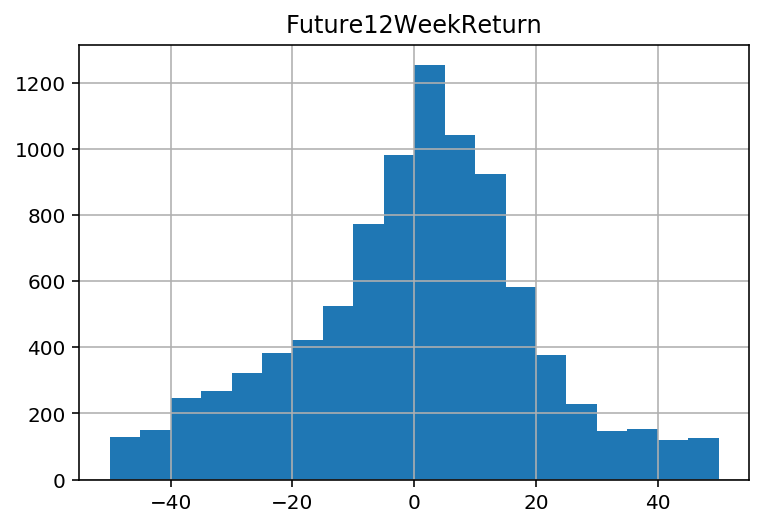

Instances:  9818
Mean:  5.919325707260576
Min:  -85.7142857143
25th percentile:  -11.160569805098092
Median:  1.7824522423994313
75th percentile:  13.583008161800562
Max:  999.0
Std deviation:  50.78460344051073
Variance:  2579.075946609934
Skew:  8.84075649496
-----
Future26WeekReturn


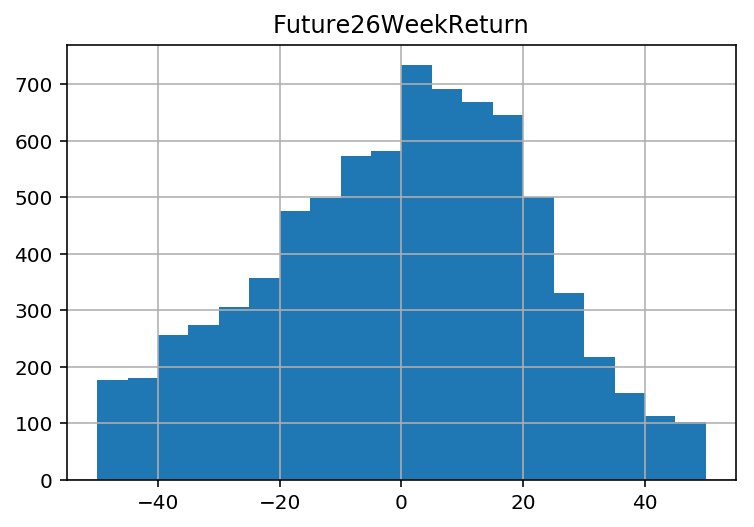

Instances:  9364
Mean:  10.334771588699455
Min:  -88.8888888889
25th percentile:  -19.370296451974458
Median:  1.7341976291179018
75th percentile:  19.093786904378867
Max:  999.0
Std deviation:  85.0476837468858
Variance:  7233.108510710302
Skew:  7.1347151569
-----
Future52WeekReturn


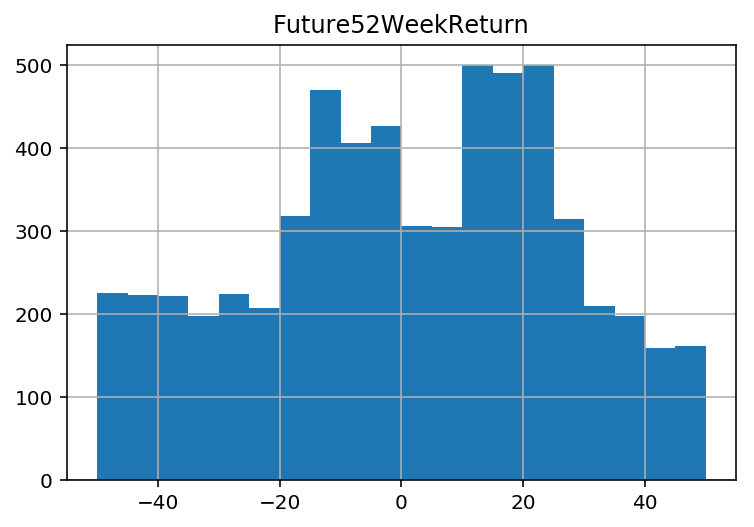

Instances:  8690
Mean:  16.45004872726538
Min:  -93.6363636364
25th percentile:  -30.412848735426678
Median:  1.215860612779621
75th percentile:  27.79264259981194
Max:  999.0
Std deviation:  97.52871843061008
Variance:  9511.850918717222
Skew:  4.06217854184
-----
Future1WeekRiskAdjustedReturn


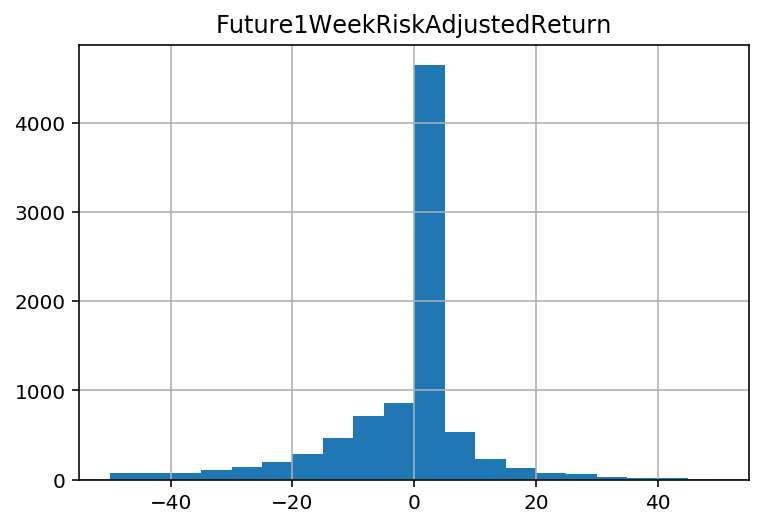

Instances:  10126
Mean:  -14.09125984570276
Min:  -99.0
25th percentile:  -12.499999999999995
Median:  0.0
75th percentile:  0.14048360134802562
Max:  115.391582844
Std deviation:  32.472950398842656
Variance:  1054.4925076056952
Skew:  -1.72090497155
-----
Future2WeekRiskAdjustedReturn


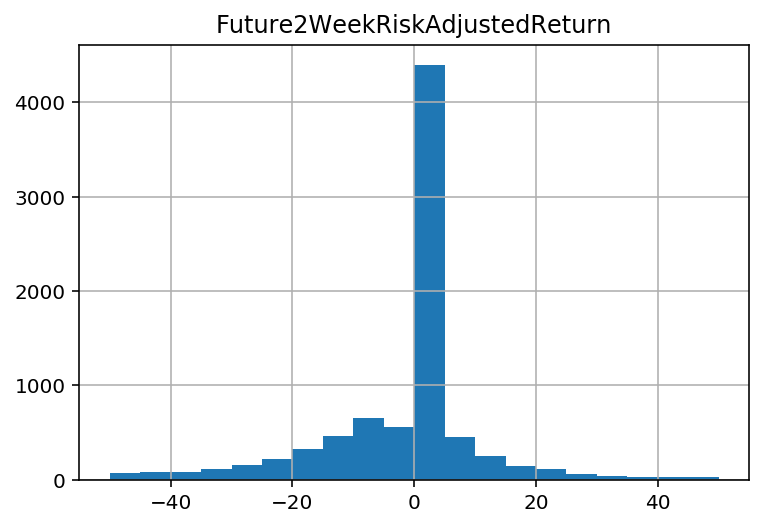

Instances:  10080
Mean:  -17.503956447035883
Min:  -99.0
25th percentile:  -19.230769230769223
Median:  0.0
75th percentile:  0.1476959020173751
Max:  228.365226481
Std deviation:  37.510398935214056
Variance:  1407.0300282789076
Skew:  -1.18912980369
-----
Future4WeekRiskAdjustedReturn


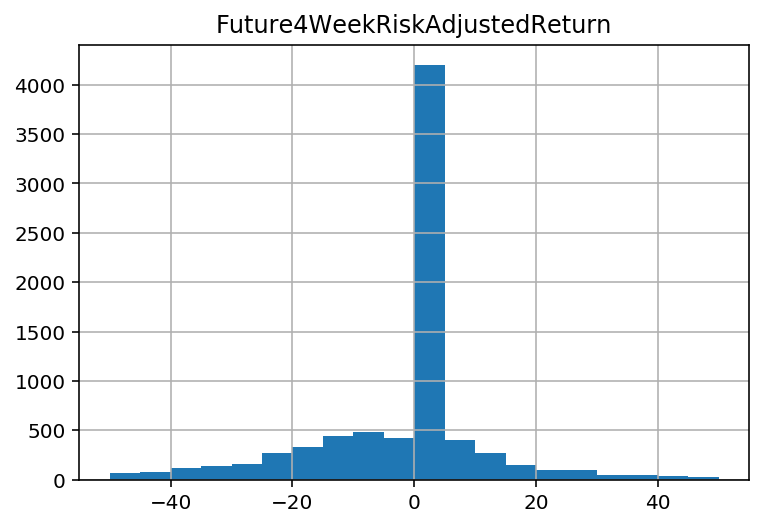

Instances:  10024
Mean:  -19.727370066699944
Min:  -99.0
25th percentile:  -26.94930263980299
Median:  0.002375070651180023
75th percentile:  0.15005981785679953
Max:  267.006871219
Std deviation:  40.982779868906455
Variance:  1679.5882457832442
Skew:  -0.806577494053
-----
Future8WeekRiskAdjustedReturn


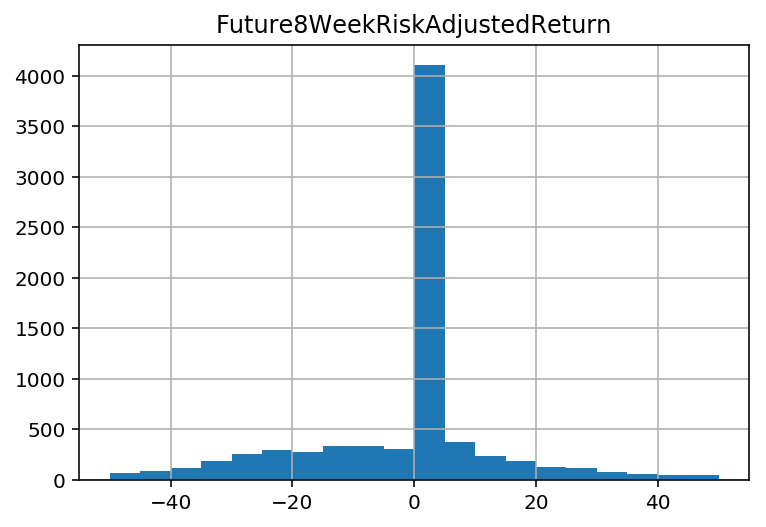

Instances:  9952
Mean:  -20.701836411969687
Min:  -99.0
25th percentile:  -33.354040840676014
Median:  0.015174409316230639
75th percentile:  0.1728778758367901
Max:  390.007773918
Std deviation:  43.5402849775897
Variance:  1895.7564159297235
Skew:  -0.403846845
-----
Future12WeekRiskAdjustedReturn


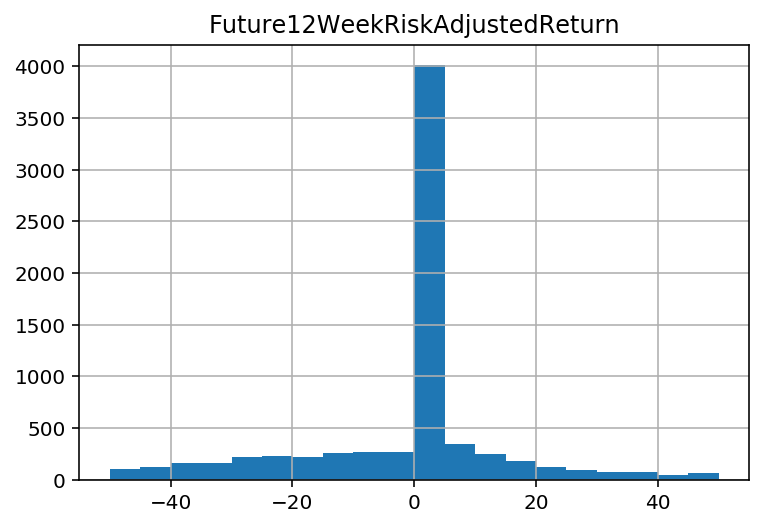

Instances:  9818
Mean:  -22.438967196057884
Min:  -99.0
25th percentile:  -45.45330205037992
Median:  0.020556269224027205
75th percentile:  0.1775568860642607
Max:  333.509907059
Std deviation:  45.52506877572544
Variance:  2072.531887034531
Skew:  -0.285431574863
-----
Future26WeekRiskAdjustedReturn


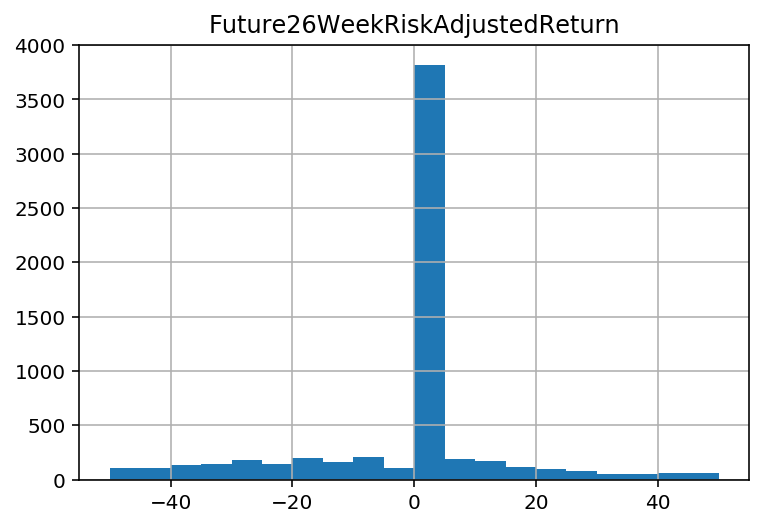

Instances:  9364
Mean:  -27.044817356958333
Min:  -99.0
25th percentile:  -99.0
Median:  0.01247639038040681
75th percentile:  0.1513306580581552
Max:  868.493201552
Std deviation:  53.25020115091301
Variance:  2835.583922612697
Skew:  1.22704019135
-----
Future52WeekRiskAdjustedReturn


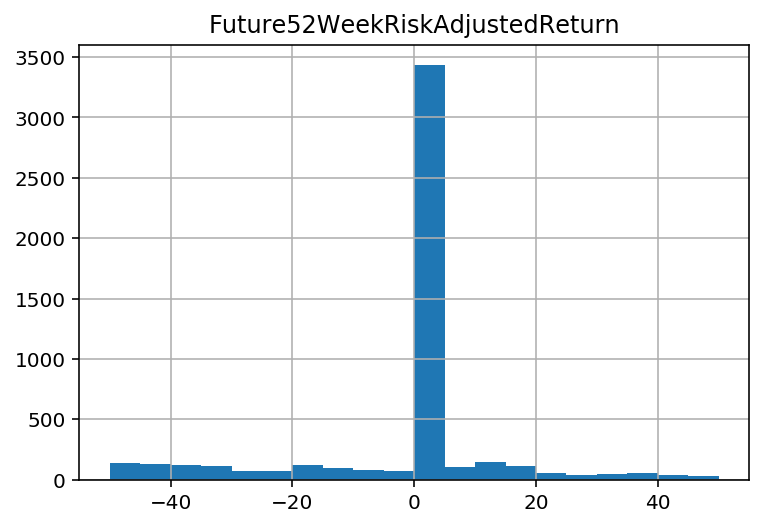

Instances:  8690
Mean:  -31.32413942817183
Min:  -99.0
25th percentile:  -99.0
Median:  0.007420931454704235
75th percentile:  0.14348474335254832
Max:  801.126788644
Std deviation:  56.06506567545929
Variance:  3143.291589193563
Skew:  0.945062947084


In [37]:
# Re-plot values for each potential target
for key in returns:
    print('-----')
    return_column = returns[key]
    print(return_column)
    filtered_data.hist(column=return_column,bins=[-50, -45, -40, -35, -30, -25, -20, -15, -10, -5, 0,
                                                  5, 10, 15, 20, 25, 30, 35, 40, 45, 50])
    pyplot.show()


    print('Instances: ', filtered_data[return_column].count())
    print('Mean: ', filtered_data[return_column].mean())
    print('Min: ', filtered_data[return_column].min())
    print('25th percentile: ', filtered_data[return_column].quantile(0.25))
    print('Median: ', filtered_data[return_column].median())
    print('75th percentile: ', filtered_data[return_column].quantile(0.75))
    print('Max: ', filtered_data[return_column].max())
    print('Std deviation: ', filtered_data[return_column].std())
    print('Variance: ', filtered_data[return_column].var())
    print('Skew: ', filtered_data[return_column].skew())


## Set-up learning data

In [38]:
# Set target column
target_column = returns['8']


In [39]:
# Remove rows missing the target column
filtered_data = filtered_data.dropna(subset=[target_column], how='all')

# Create y_data
y_data = filtered_data[target_column].values


# Filter down data to the X columns being used
filtered_data = filtered_data[data_columns]


print(filtered_data.dtypes)

print('Min:',min(y_data),', Max:', max(y_data))

symbol                                object
quoteDate                             object
adjustedPrice                        float64
volume                                 int64
previousClose                        float64
change                               float64
changeInPercent                      float64
52WeekHigh                           float64
52WeekLow                            float64
changeFrom52WeekHigh                 float64
changeFrom52WeekLow                  float64
percebtChangeFrom52WeekHigh          float64
percentChangeFrom52WeekLow           float64
Price200DayAverage                   float64
Price52WeekPercChange                float64
1WeekVolatility                      float64
2WeekVolatility                      float64
4WeekVolatility                      float64
8WeekVolatility                      float64
12WeekVolatility                     float64
26WeekVolatility                     float64
52WeekVolatility                     float64
4WeekBolli

## Convert non-numerical values

In [40]:
from datetime import datetime as dt
from dateutil.parser import parse

def is_date(string):
    try: 
        parse(string)
        return True
    except:
        return False

def convert_date_to_ordinal(date_val):
    if(pd.isnull(date_val)):
        return -99999
    
    elif(type(date_val) is str):
        if(is_date(date_val)):
            return parse(date_val).toordinal()
        else:
            return -99999

    elif(type(date_val) is int or type(date_val) is float):
        return date_val
    

# Fix date values - convert to ordinals
filtered_data['quoteDate'] = filtered_data['quoteDate'].apply(lambda x: convert_date_to_ordinal(x))

# print(filtered_data['exDividendDate'].apply(lambda x: convert_date_to_ordinal(x)))
filtered_data['exDividendDate'] = filtered_data['exDividendDate'].apply(lambda x: convert_date_to_ordinal(x))

print(filtered_data.head(5))

# Convert categorical variables to boolean fields
#  4WeekBollingerPrediction              
#  4WeekBollingerType                    
#  12WeekBollingerPrediction             
#  12WeekBollingerType                   

filtered_data = pd.get_dummies(data=filtered_data, columns=['symbol', '4WeekBollingerPrediction', '4WeekBollingerType', 
                                                            '12WeekBollingerPrediction', '12WeekBollingerType'])


# Fill nan values with placeholder and check for null values
filtered_data = filtered_data.fillna(-99999)
print(pd.isnull(filtered_data).any())

     symbol  quoteDate  adjustedPrice  volume  previousClose  change  \
3369    AOU     734388           0.26   16100           0.26     0.0   
3370    AOU     734389           0.25    6000           0.25     0.0   
3372    AOU     734393           0.24    6000           0.24     0.0   
3374    AOU     734396           0.26   37000           0.26     0.0   
3377    AOU     734402           0.27   34100           0.27     0.0   

      changeInPercent  52WeekHigh  52WeekLow  changeFrom52WeekHigh  \
3369              1.0         0.3       0.25                 -0.04   
3370              1.0         0.3       0.25                 -0.05   
3372              1.0         0.3       0.23                 -0.06   
3374              1.0         0.3       0.23                 -0.04   
3377              1.0         0.3       0.23                 -0.03   

      changeFrom52WeekLow  percebtChangeFrom52WeekHigh  \
3369                 0.01                    -0.133333   
3370                 0.00     

In [41]:
# Check data types
print(filtered_data.dtypes)

# Copy over X_data columns
X_data = filtered_data.values


# Check how many fields in X_data
print(X_data.shape)


quoteDate                              int64
adjustedPrice                        float64
volume                                 int64
previousClose                        float64
change                               float64
changeInPercent                      float64
52WeekHigh                           float64
52WeekLow                            float64
changeFrom52WeekHigh                 float64
changeFrom52WeekLow                  float64
percebtChangeFrom52WeekHigh          float64
percentChangeFrom52WeekLow           float64
Price200DayAverage                   float64
Price52WeekPercChange                float64
1WeekVolatility                      float64
2WeekVolatility                      float64
4WeekVolatility                      float64
8WeekVolatility                      float64
12WeekVolatility                     float64
26WeekVolatility                     float64
52WeekVolatility                     float64
allordpreviousclose                  float64
allordchan

## Run xgboost with early stopping

Training for Future8WeekReturn
[0]	validation_0-mae:10.2868
Will train until validation_0-mae hasn't improved in 50 rounds.
[1]	validation_0-mae:9.6612
[2]	validation_0-mae:9.09463
[3]	validation_0-mae:8.53366
[4]	validation_0-mae:8.03909
[5]	validation_0-mae:7.54698
[6]	validation_0-mae:7.11925
[7]	validation_0-mae:6.71681
[8]	validation_0-mae:6.34198
[9]	validation_0-mae:6.01473
[10]	validation_0-mae:5.7201
[11]	validation_0-mae:5.43258
[12]	validation_0-mae:5.17737
[13]	validation_0-mae:4.94079
[14]	validation_0-mae:4.71108
[15]	validation_0-mae:4.51323
[16]	validation_0-mae:4.32168
[17]	validation_0-mae:4.15477
[18]	validation_0-mae:4.00793
[19]	validation_0-mae:3.86705
[20]	validation_0-mae:3.74829
[21]	validation_0-mae:3.63026
[22]	validation_0-mae:3.52932
[23]	validation_0-mae:3.43019
[24]	validation_0-mae:3.33908
[25]	validation_0-mae:3.26227
[26]	validation_0-mae:3.19158
[27]	validation_0-mae:3.12844
[28]	validation_0-mae:3.07681
[29]	validation_0-mae:3.01816
[30]	validation_0

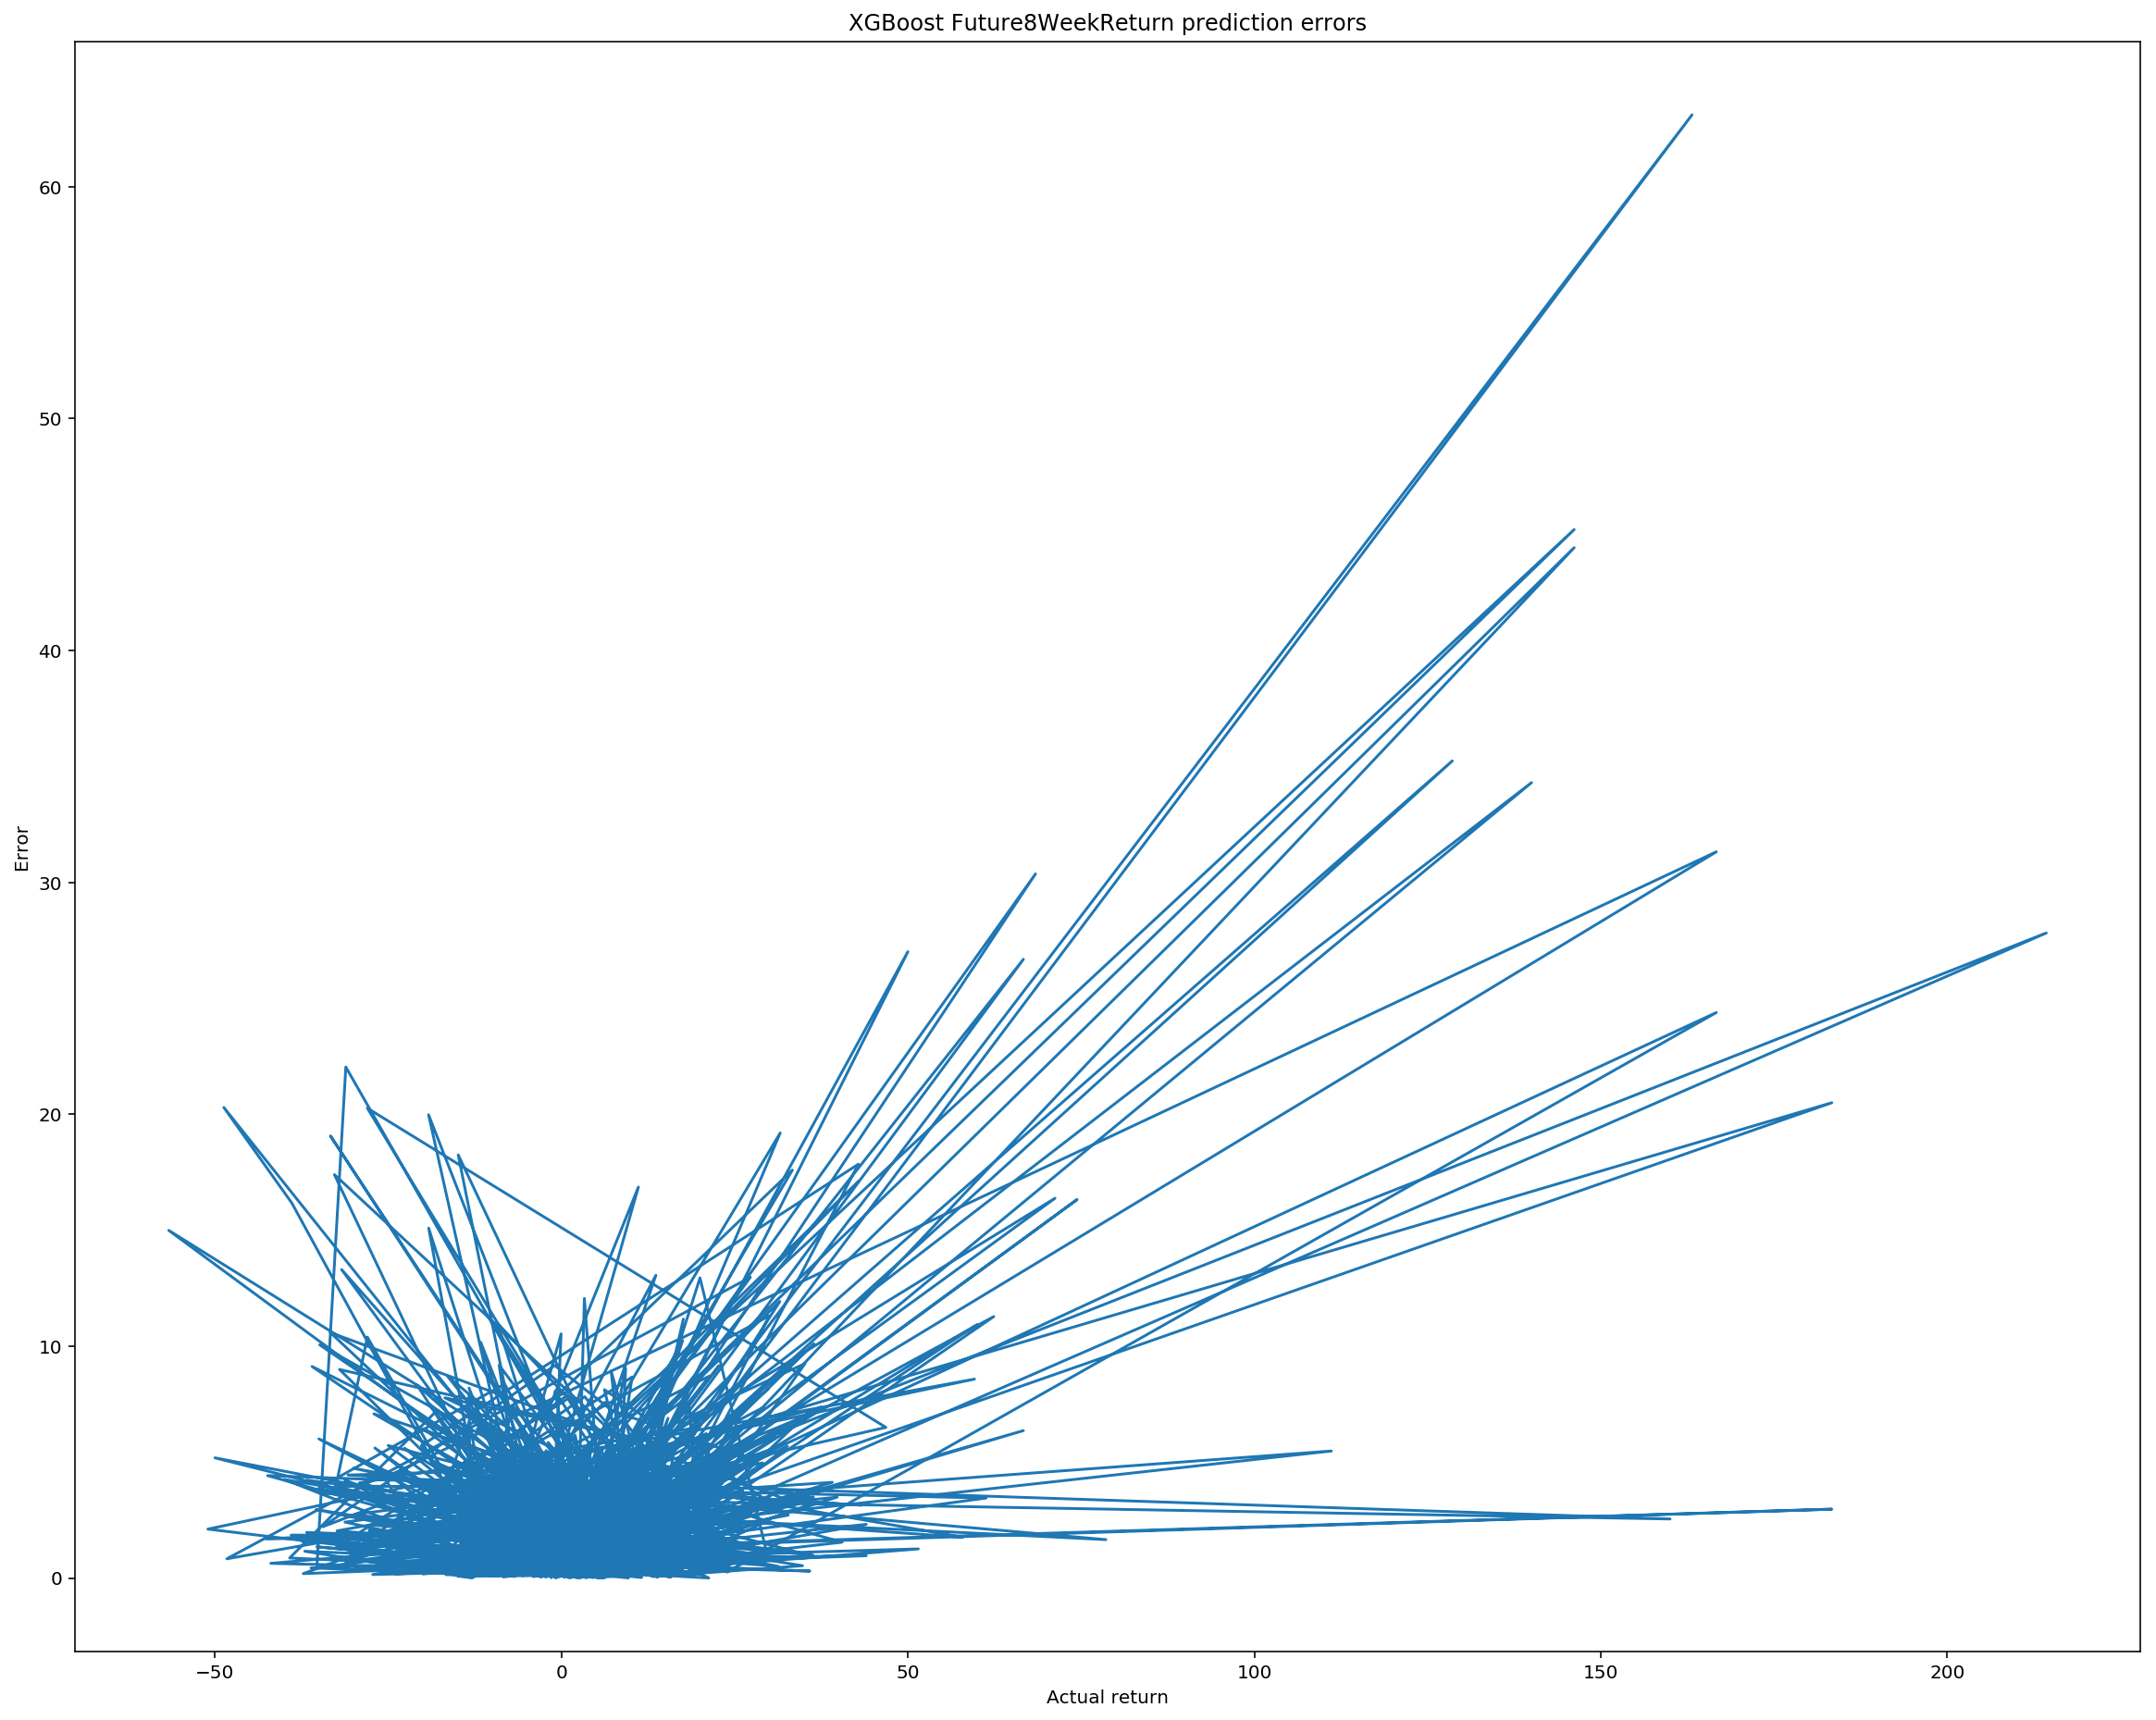

In [9]:
from sklearn.metrics import mean_absolute_error
import time

# Split into train and test data
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, train_size=0.7, test_size=0.3)

print('Training for', target_column)

# Fit model with training set
start = time.time()
model = xgb.XGBRegressor(base_score=0.35, colsample_bylevel=0.8, colsample_bytree=0.8, 
                         gamma=0, learning_rate=0.075, max_delta_step=0, max_depth=200, 
                         min_child_weight=0, missing=None, n_estimators=20000, nthread=-1, 
                         reg_alpha=0.4, reg_lambda=0.3, scale_pos_weight=0, subsample=0.8)
eval_set = [(X_test, y_test)]
model.fit(X_train, y_train, early_stopping_rounds=50, eval_metric="mae", eval_set=eval_set, verbose=True)
# Output model settings
fit_time = time.time()
print(model)
print('Fit elapsed time: %d' % (fit_time - start))


# make predictions for test data
predictions = model.predict(X_test)
predition_time = time.time()
print('Prediction elapsed time: %d' % (predition_time - fit_time))

# evaluate predictions
mae = mean_absolute_error(y_test, predictions)
print('Mean absolute error:', mae)

# Evaluate distribution of errors - get error amount for each prediction
y_errors = np.absolute(np.subtract(y_test, predictions))

# Plot the distribution of errors
pyplot.figure(figsize=(20, 16))
plot_title = 'XGBoost ' + target_column + ' prediction errors'
pyplot.plot(y_test, y_errors)
pyplot.ylabel('Error')
pyplot.xlabel('Actual return')
pyplot.title(plot_title)
pyplot.show(plot_title)

# XGBRegressor(base_score=0.35, colsample_bylevel=0.8, colsample_bytree=0.8,
#        gamma=0, learning_rate=0.075, max_delta_step=0, max_depth=70,
#        min_child_weight=0, missing=None, n_estimators=20000, nthread=-1,
#        objective='reg:linear', reg_alpha=0.4, reg_lambda=0.3,
#        scale_pos_weight=0, seed=0, silent=True, subsample=0.8)
# Fit elapsed time: 46
# Prediction elapsed time: 0
# Mean absolute error: 2.37654838506

## CVGridSearch with early stopping

In [ ]:
from sklearn.metrics import mean_absolute_error
import time

# Split into train and test data
print('Splitting data')
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, train_size=0.75, test_size=0.25)

kfold = KFold(n_splits=4, shuffle=True)

print('Training for', target_column)

# Fit model with training set
start = time.time()
model = xgb.XGBRegressor(nthread=-1, n_estimators=10000, learning_rate=0.05, max_depth=50)
eval_set = [(X_test, y_test)]
over_fifty = [i/100.0 for i in range(65, 101, 5)]
under_fifty = [i/100.0 for i in range(0, 36, 5)]

paramGrid = {
            #"max_depth": [i for i in range(25, 151, 25)],
            #"learning_rate": [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]#,
            "min_child_weight": over_fifty,
            "gamma": under_fifty#,
            #"scale_pos_weight": over_fifty,
            #"colsample_bylevel": over_fifty#,
            #"colsample_bytree": over_fifty,
            #"subsample": over_fifty#,
            #"max_delta_step": under_fifty,
            #"reg_lambda": over_fifty#,
            #"reg_alpha": under_fifty
            #"reg_lambda_bias": under_fifty
            }

fit_params = {
            "early_stopping_rounds": 50, 
            "eval_metric": "mae", 
            "eval_set": eval_set, 
            "verbose": False
            }

grid_search = GridSearchCV(model, paramGrid, scoring="r2", fit_params=fit_params, verbose=2, cv=kfold)

grid_result = grid_search.fit(X_train, y_train)
# Output model settings
fit_time = time.time()
print('Fit elapsed time: %d' % (fit_time - start))

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

params = grid_result.cv_results_['params']


Splitting data
Training for Future8WeekReturn
Fitting 4 folds for each of 64 candidates, totalling 256 fits
[CV] gamma=0.0, min_child_weight=0.65 ................................
[CV] ................. gamma=0.0, min_child_weight=0.65, total=  25.7s
[CV] gamma=0.0, min_child_weight=0.65 ................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   25.8s remaining:    0.0s


[CV] ................. gamma=0.0, min_child_weight=0.65, total=  24.2s
[CV] gamma=0.0, min_child_weight=0.65 ................................
[CV] ................. gamma=0.0, min_child_weight=0.65, total=  25.3s
[CV] gamma=0.0, min_child_weight=0.65 ................................
[CV] ................. gamma=0.0, min_child_weight=0.65, total=  24.0s
[CV] gamma=0.0, min_child_weight=0.7 .................................
[CV] .................. gamma=0.0, min_child_weight=0.7, total=  25.4s
[CV] gamma=0.0, min_child_weight=0.7 .................................
[CV] .................. gamma=0.0, min_child_weight=0.7, total=  24.0s
[CV] gamma=0.0, min_child_weight=0.7 .................................
[CV] .................. gamma=0.0, min_child_weight=0.7, total=  25.3s
[CV] gamma=0.0, min_child_weight=0.7 .................................
[CV] .................. gamma=0.0, min_child_weight=0.7, total=  23.9s
[CV] gamma=0.0, min_child_weight=0.75 ................................
[CV] .

## Run xgboost

In [ ]:
from sklearn.metrics import mean_absolute_error
import time

# Split into train and test data
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, train_size=0.7, test_size=0.3)

print('Training for', target_column)

# Fit model with training set
start = time.time()
model = xgb.XGBRegressor(base_score=0.35, colsample_bylevel=0.8, colsample_bytree=0.8, 
                         gamma=0, learning_rate=0.075, max_delta_step=0, max_depth=70, 
                         min_child_weight=0, missing=None, n_estimators=9500, nthread=-1, 
                         reg_alpha=0.4, reg_lambda=0.3, scale_pos_weight=0, subsample=0.8)
model.fit(X_train, y_train)
# Output model settings
fit_time = time.time()
print(model)
print('Fit elapsed time: %d' % (fit_time - start))


# make predictions for test data
predictions = model.predict(X_test)
predition_time = time.time()
print('Prediction elapsed time: %d' % (predition_time - fit_time))

# evaluate predictions
mae = mean_absolute_error(y_test, predictions)
print('Mean absolute error:', mae)

# Evaluate distribution of errors - get error amount for each prediction
y_errors = np.absolute(np.subtract(y_test, predictions))

# Plot the distribution of errors
pyplot.figure(figsize=(20, 16))
plot_title = 'XGBoost ' + target_column + ' prediction errors'
pyplot.plot(y_test, y_errors)
pyplot.ylabel('Error')
pyplot.xlabel('Actual return')
pyplot.title(plot_title)
pyplot.show(plot_title)

# ---------- 8 Week Returns ---------------------------------------------
    # --- All data ---
    # XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
    #       learning_rate=0.1, max_delta_step=0, max_depth=3,
    #       min_child_weight=1, missing=None, n_estimators=100, nthread=1,
    #       objective='reg:linear', reg_alpha=0, reg_lambda=1,
    #       scale_pos_weight=1, seed=0, silent=True, subsample=1)
    # Mean absolute error:  27.209411857320072

    # --- Removed outliers: n_estimators=100 ---
    # XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
    #       learning_rate=0.1, max_delta_step=0, max_depth=3,
    #       min_child_weight=1, missing=None, n_estimators=100, nthread=1,
    #       objective='reg:linear', reg_alpha=0, reg_lambda=1,
    #       scale_pos_weight=1, seed=0, silent=True, subsample=1)
    # Mean absolute error:  23.8139769746

    # --- Removed outliers: n_estimators=200 ---
    # XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
    #       learning_rate=0.1, max_delta_step=0, max_depth=3,
    #       min_child_weight=1, missing=None, n_estimators=200, nthread=1,
    #       objective='reg:linear', reg_alpha=0, reg_lambda=1,
    #       scale_pos_weight=1, seed=0, silent=True, subsample=1)
    # Mean absolute error:  21.9375376132

    # --- Removed outliers: n_estimators=500 ---
    # XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
    #       learning_rate=0.1, max_delta_step=0, max_depth=3,
    #       min_child_weight=1, missing=None, n_estimators=500, nthread=-1,
    #       objective='reg:linear', reg_alpha=0, reg_lambda=1,
    #       scale_pos_weight=1, seed=0, silent=True, subsample=1)
    # Mean absolute error:  21.9761006957
    
    
# ---------- 8 Week Risk Adjusted Returns -------------------------------------
    # --- All data ---
    # XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
    #   learning_rate=0.1, max_delta_step=0, max_depth=3,
    #   min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
    #   objective='reg:linear', reg_alpha=0, reg_lambda=1,
    #   scale_pos_weight=1, seed=0, silent=True, subsample=1)
    # Fit elapsed time: 193
    # Prediction elapsed time: 3
    # Mean absolute error: 456.680567416


In [ ]:
# Plot the distribution of errors
pyplot.figure(figsize=(20, 16))

print( min(y_test))
print(max(y_test))


plot_title = 'XGBoost ' + target_column + ' prediction errors'
pyplot.plot(y_test, y_errors)
pyplot.ylabel('Error')
pyplot.xlabel('Actual return')
pyplot.xlim([ min(y_test),max(y_test)])
pyplot.title(plot_title)
pyplot.show(plot_title)

## Xgboost for one symbol

In [ ]:
from sklearn.metrics import mean_absolute_error
import time

# Split into train and test data
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, train_size=0.7, test_size=0.3)

print('Training for', target_column)

# Fit model with training set
model = xgb.XGBRegressor(nthread=-1, colsample_bylevel=0.8, colsample_bytree=0.8,
                         learning_rate=0.075, max_depth=10,n_estimators=9500, 
                         subsample=0.8)
start = time.time()
model.fit(X_train, y_train)
elapsed = time.time() - start

# Output model settings
print(model)
print('Fit elapsed time: %d' % (elapsed))



start = time.time()
# make predictions for test data
predictions = model.predict(X_test)
elapsed = time.time() - start
print('Prediction elapsed time: %d' % (elapsed))

# evaluate predictions
mae = mean_absolute_error(y_test, predictions)
print('Mean absolute error:', mae)

# Evaluate distribution of errors - get error amount for each prediction
y_errors = np.absolute(np.subtract(y_test, predictions))

# Plot the distribution of errors
pyplot.figure(figsize=(20, 16))
plot_title = 'XGBoost ' + target_column + ' prediction errors'
pyplot.plot(y_test, y_errors)
pyplot.ylabel('Error')
pyplot.xlabel('Actual return')
pyplot.title(plot_title)
pyplot.show(plot_title)

# ---------- 8 Week Returns - CBA  ---------------------------------------------
    # Training for Future8WeekReturn
    # XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
    #        learning_rate=0.1, max_delta_step=0, max_depth=3,
    #        min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
    #        objective='reg:linear', reg_alpha=0, reg_lambda=1,
    #        scale_pos_weight=1, seed=0, silent=True, subsample=1)
    # Fit elapsed time: 0
    # Prediction elapsed time: 0
    # Mean absolute error: 2.85405055196

#     Training for Future8WeekReturn
#     XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
#            learning_rate=0.1, max_delta_step=0, max_depth=3,
#            min_child_weight=1, missing=None, n_estimators=500, nthread=-1,
#            objective='reg:linear', reg_alpha=0, reg_lambda=1,
#            scale_pos_weight=1, seed=0, silent=True, subsample=1)
#     Fit elapsed time: 1
#     Prediction elapsed time: 0
#     Mean absolute error: 1.87473924615

#     Training for Future8WeekReturn
#     XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
#            learning_rate=0.1, max_delta_step=0, max_depth=3,
#            min_child_weight=1, missing=None, n_estimators=1000, nthread=-1,
#            objective='reg:linear', reg_alpha=0, reg_lambda=1,
#            scale_pos_weight=1, seed=0, silent=True, subsample=1)
#     Fit elapsed time: 2
#     Prediction elapsed time: 0
#     Mean absolute error: 1.82999759228

#     Training for Future8WeekReturn
#     XGBRegressor(base_score=0.5, colsample_bylevel=0.8, colsample_bytree=0.8,
#            gamma=0, learning_rate=0.075, max_delta_step=0, max_depth=10,
#            min_child_weight=1, missing=None, n_estimators=9500, nthread=-1,
#            objective='reg:linear', reg_alpha=0, reg_lambda=1,
#            scale_pos_weight=1, seed=0, silent=True, subsample=0.8)
#     Fit elapsed time: 14
#     Prediction elapsed time: 0
#     Mean absolute error: 1.55688219974


## Optimise single symbol model

In [ ]:
from sklearn.metrics import mean_absolute_error
import time

def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return array[idx]

if __name__ == "__main__":
    print("Work through parameter optimization")

    # Split into train and test data
    X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, train_size=0.7, test_size=0.3)

    
    model = xgb.XGBRegressor(nthread=-1)

    kfold = KFold(n_splits=5, shuffle=True)


    print("Set non-optimised baseline")
    round_err = []
    for r in range(0, 5):
        err = []
        for train_index, test_index in kfold.split(X_data):
            model.fit(X_data[train_index],y_data[train_index])
            predictions = model.predict(X_data[test_index])
            actuals = y_data[test_index]
            err.append(mean_absolute_error(actuals, predictions))

        print(np.mean(err))
        round_err.append(np.mean(err))

    baseline_error = np.mean(round_err)

    print("Average baseline error: %f" % baseline_error)
    print('-----')

    n_estimators=[7000, 7500, 8000, 8500, 9000, 9500, 10000]
        
    param_grid = dict(n_estimators=n_estimators)

    grid_search = GridSearchCV(model,param_grid, scoring="neg_mean_absolute_error", cv=kfold, verbose=1, n_jobs=-1)
    n_estimators_r = []

    for r in range(0, 5):
        grid_result = grid_search.fit(X_data, y_data)
        # summarize results
        print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
        n_estimators_r.append(grid_result.best_params_['n_estimators'])
        means = grid_result.cv_results_['mean_test_score']
        stds = grid_result.cv_results_['std_test_score']
        params = grid_result.cv_results_['params']

    n_estimators = find_nearest(n_estimators_r, np.mean(n_estimators_r))
    
    model.n_estimators = n_estimators
    
    print("Averaged best n_estimators: %f " % n_estimators)
    print('-----')  
        
    learning_rate = [0.025, 0.05, 0.075, 0.1, 0.2, 0.3]
    param_grid = dict(learning_rate=learning_rate)

    grid_search = GridSearchCV(model,param_grid, scoring="neg_mean_absolute_error", cv=kfold, verbose=1, n_jobs=-1)
    learning_rates = []

    for r in range(0, 5):
        grid_result = grid_search.fit(X_data, y_data)
        # summarize results
        print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
        learning_rates.append(grid_result.best_params_['learning_rate'])
        means = grid_result.cv_results_['mean_test_score']
        stds = grid_result.cv_results_['std_test_score']
        params = grid_result.cv_results_['params']

    learning_rate = find_nearest(learning_rates, np.mean(learning_rates))
    
    model.learning_rate = learning_rate
    
    print("Averaged best learning rate: %f " % learning_rate)
    print('-----')     

    max_depth = [2, 4, 6, 8, 10, 12, 14]
    param_grid = dict(max_depth=max_depth)

    grid_search = GridSearchCV(model,param_grid, scoring="neg_mean_absolute_error", cv=kfold, verbose=1, n_jobs=-1)
    max_depths = []

    for r in range(0, 5):
        grid_result = grid_search.fit(X_data, y_data)
        # summarize results
        print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
        max_depths.append(grid_result.best_params_['max_depth'])
        means = grid_result.cv_results_['mean_test_score']
        stds = grid_result.cv_results_['std_test_score']
        params = grid_result.cv_results_['params']

    max_depth = find_nearest(max_depths, np.mean(max_depths))
    
    model.max_depth = max_depth
    
    print("Averaged best max depth: %f " % max_depth)
    print('-----')
    samples = [0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1.0] #[i/100.0 for i in range(60,101, 5)]
    param_grid = dict(subsample=samples)

    grid_search = GridSearchCV(model,param_grid, scoring="neg_mean_absolute_error", cv=kfold, verbose=1, n_jobs=-1)
    subsamples = []

    for r in range(0, 5):
        grid_result = grid_search.fit(X_data, y_data)
        # summarize results
        print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
        subsamples.append(grid_result.best_params_['subsample'])
        means = grid_result.cv_results_['mean_test_score']
        stds = grid_result.cv_results_['std_test_score']
        params = grid_result.cv_results_['params']

    subsample = find_nearest(subsamples, np.mean(subsamples))
    
    model.subsample = subsample
    
    print("Averaged best subsample: %f " % subsample)
    print('-----')

    param_grid = dict(colsample_bytree=samples)

    grid_search = GridSearchCV(model,param_grid, scoring="neg_mean_absolute_error", cv=kfold, verbose=1, n_jobs=-1)
    colsample_bytrees = []

    for r in range(0, 5):
        grid_result = grid_search.fit(X_data, y_data)
        # summarize results
        print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
        colsample_bytrees.append(grid_result.best_params_['colsample_bytree'])
        means = grid_result.cv_results_['mean_test_score']
        stds = grid_result.cv_results_['std_test_score']
        params = grid_result.cv_results_['params']

    colsample_bytree = find_nearest(colsample_bytrees, np.mean(colsample_bytrees))
    
    model.colsample_bytree = colsample_bytree
    
    print("Averaged best colsample_bytree: %f " % colsample_bytree)
    print('-----')

    param_grid = dict(colsample_bylevel=samples)

    grid_search = GridSearchCV(model,param_grid, scoring="neg_mean_absolute_error", cv=kfold, verbose=1, n_jobs=-1)
    colsample_bylevels = []

    for r in range(0, 5):
        grid_result = grid_search.fit(X_data, y_data)
        # summarize results
        print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
        colsample_bylevels.append(grid_result.best_params_['colsample_bylevel'])
        means = grid_result.cv_results_['mean_test_score']
        stds = grid_result.cv_results_['std_test_score']
        params = grid_result.cv_results_['params']

    colsample_bylevel = find_nearest(colsample_bylevels, np.mean(colsample_bylevels))
    
    model.colsample_bylevel = colsample_bylevel
    
    print("Averaged best colsample_bylevel: %f " % colsample_bylevel)
    print('-----')

    # Retest with new parameters
    round_err = []
    for r in range(0, 5):
        err = []
        for train_index, test_index in kfold.split(X_data):
            xgb_model = xgb.XGBRegressor(nthread=-1, colsample_bytree = colsample_bytree, 
                                         learning_rate = learning_rate, max_depth = max_depth, 
                                         n_estimators = n_estimators, subsample = subsample,
                                         colsample_bylevel = colsample_bylevel)
            xgb_model.fit(X_data[train_index],y_data[train_index])
            predictions = model.predict(X_data[test_index])
            actuals = y_data[test_index]
            err.append(mean_absolute_error(actuals, predictions))
               
        print(np.mean(err))
        round_err.append(np.mean(err))

    tuned_error = np.mean(round_err)

    print("Average tuned error: %s" % tuned_error)
    improvement = baseline_error - tuned_error
    print('-----')
    print('Optimisation improvement result: %s, %s%%' % (improvement, improvement / baseline_error * 100))
    print('-----')
    print(xgb_model)
    print('-----')

## Secondary parameters

In [ ]:
    weights = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    
#     model.eval_metric = 'mae'
    
#     gamma = [0]
#     param_grid = dict(gamma=gamma)

#     grid_search = GridSearchCV(model, param_grid, scoring="neg_mean_absolute_error", cv=kfold, verbose=1, n_jobs=-1)
#     gammas = []

#     for r in range(0, 5):
#         grid_result = grid_search.fit(X_data, y_data)
#         # summarize results
#         print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
#         gammas.append(grid_result.best_params_['gamma'])
#         means = grid_result.cv_results_['mean_test_score']
#         stds = grid_result.cv_results_['std_test_score']
#         params = grid_result.cv_results_['params']

#     gamma = find_nearest(gammas, np.mean(gammas))
    
#     model.gamma = gamma
    
#     print("Averaged best gamma: %f " % gamma)
#     print('-----')    
    
#     min_child_weight = [0]
#     param_grid = dict(min_child_weight=min_child_weight)

#     grid_search = GridSearchCV(model,param_grid, scoring="neg_mean_absolute_error", cv=kfold, verbose=1, n_jobs=-1)
#     min_child_weights = []

#     for r in range(0, 5):
#         grid_result = grid_search.fit(X_data, y_data)
#         # summarize results
#         print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
#         min_child_weights.append(grid_result.best_params_['min_child_weight'])
#         means = grid_result.cv_results_['mean_test_score']
#         stds = grid_result.cv_results_['std_test_score']
#         params = grid_result.cv_results_['params']

#     min_child_weight = find_nearest(min_child_weights, np.mean(min_child_weights))
    
#     model.min_child_weight = min_child_weight
    
#     print("Averaged best min_child_weight: %f " % min_child_weight)
#     print('-----')

    gamma = 0
    min_child_weight = 0

    reg_lambda = [0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
    param_grid = dict(reg_lambda=reg_lambda)

    grid_search = GridSearchCV(model,param_grid, scoring="neg_mean_absolute_error", cv=kfold, verbose=1, n_jobs=-1)
    reg_lambdas = []

    for r in range(0, 5):
        grid_result = grid_search.fit(X_data, y_data)
        # summarize results
        print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
        reg_lambdas.append(grid_result.best_params_['reg_lambda'])
        means = grid_result.cv_results_['mean_test_score']
        stds = grid_result.cv_results_['std_test_score']
        params = grid_result.cv_results_['params']

    reg_lambda = find_nearest(reg_lambdas, np.mean(reg_lambdas))
    
    model.reg_lambda = reg_lambda
    
    print("Averaged best reg_lambda: %f " % reg_lambda)
    print('-----')

    scale_pos_weight = [0, 1, 2, 3, 4, 5]
    param_grid = dict(scale_pos_weight=scale_pos_weight)

    grid_search = GridSearchCV(model,param_grid, scoring="neg_mean_absolute_error", cv=kfold, verbose=1, n_jobs=-1)
    scale_pos_weights = []

    for r in range(0, 5):
        grid_result = grid_search.fit(X_data, y_data)
        # summarize results
        print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
        scale_pos_weights.append(grid_result.best_params_['scale_pos_weight'])
        means = grid_result.cv_results_['mean_test_score']
        stds = grid_result.cv_results_['std_test_score']
        params = grid_result.cv_results_['params']

    scale_pos_weight = find_nearest(scale_pos_weights, np.mean(scale_pos_weights))
    
    model.scale_pos_weight = scale_pos_weight
    
    print("Averaged best scale_pos_weight: %f " % scale_pos_weight)
    print('-----')
    

    reg_alpha = [0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6]
    param_grid = dict(reg_alpha=reg_alpha)

    grid_search = GridSearchCV(model,param_grid, scoring="neg_mean_absolute_error", cv=kfold, verbose=1, n_jobs=-1)
    reg_alphas = []

    for r in range(0, 5):
        grid_result = grid_search.fit(X_data, y_data)
        # summarize results
        print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
        reg_alphas.append(grid_result.best_params_['reg_alpha'])
        means = grid_result.cv_results_['mean_test_score']
        stds = grid_result.cv_results_['std_test_score']
        params = grid_result.cv_results_['params']

    reg_alpha = find_nearest(reg_alphas, np.mean(reg_alphas))
    
    model.reg_alpha = reg_alpha
    
    print("Averaged best reg_alpha: %f " % reg_alpha)
    print('-----')
        
    base_score = [0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6]
    param_grid = dict(base_score=base_score)

    grid_search = GridSearchCV(model,param_grid, scoring="neg_mean_absolute_error", cv=kfold, verbose=1, n_jobs=-1)
    base_scores = []

    for r in range(0, 5):
        grid_result = grid_search.fit(X_data, y_data)
        # summarize results
        print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
        base_scores.append(grid_result.best_params_['base_score'])
        means = grid_result.cv_results_['mean_test_score']
        stds = grid_result.cv_results_['std_test_score']
        params = grid_result.cv_results_['params']

    base_score = find_nearest(base_scores, np.mean(base_scores))
    
    model.base_score = base_score
    
    print("Averaged best base_score: %f " % base_score)
    print('-----')

    
    # Retest with new parameters
    round_err = []
    for r in range(0, 5):
        err = []
        for train_index, test_index in kfold.split(X_data):
            xgb_model = xgb.XGBRegressor(nthread=-1, colsample_bytree = colsample_bytree, gamma=gamma, 
                                         learning_rate = learning_rate, max_depth = max_depth, 
                                         n_estimators = n_estimators, subsample = subsample,
                                         colsample_bylevel = colsample_bylevel, base_score = base_score,
                                         reg_alpha = reg_alpha, scale_pos_weight = scale_pos_weight,
                                         reg_lambda = reg_lambda, min_child_weight = min_child_weight)
            xgb_model.fit(X_data[train_index],y_data[train_index])
            predictions = model.predict(X_data[test_index])
            actuals = y_data[test_index]
            err.append(mean_absolute_error(actuals, predictions))
               
        print(np.mean(err))
        round_err.append(np.mean(err))

    tuned_error = np.mean(round_err)

    print("Average tuned error: %s" % tuned_error)
    improvement = baseline_error - tuned_error
    print('-----')
    print('Optimisation improvement result: %s, %s%%' % (improvement, improvement / baseline_error * 100))
    print('-----')
    print(xgb_model)
    print('-----')

In [ ]:
    model.max_depth = 70
    n_estimators=[7000, 7500, 8000, 8500, 9000, 9500, 10000]
        
    param_grid = dict(n_estimators=n_estimators)

    grid_search = GridSearchCV(model,param_grid, scoring="neg_mean_absolute_error", cv=kfold, verbose=1, n_jobs=-1)
    n_estimators_r = []

    for r in range(0, 5):
        grid_result = grid_search.fit(X_data, y_data)
        # summarize results
        print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
        n_estimators_r.append(grid_result.best_params_['n_estimators'])
        means = grid_result.cv_results_['mean_test_score']
        stds = grid_result.cv_results_['std_test_score']
        params = grid_result.cv_results_['params']

    n_estimators = find_nearest(n_estimators_r, np.mean(n_estimators_r))
    
    model.n_estimators = n_estimators
    
    print("Averaged best n_estimators: %f " % n_estimators)
    print('-----')  

## Compare model to baseline

In [24]:
import time
from sklearn.metrics import r2_score

kfold = KFold(n_splits=5, shuffle=True)

# Test with base parameters
print('-----')
print('Base model')

base_errs = []
base_r2s = []
for r in range(0, 5):
    err = []
    r2 = []
    for train_index, test_index in kfold.split(X_data):
        start = time.time()
        base_model = xgb.XGBRegressor(nthread=-1)
        base_model.fit(X_data[train_index],y_data[train_index])
        fit_time = time.time()
        predictions = base_model.predict(X_data[test_index])
        prediction_time = time.time()
        actuals = y_data[test_index]
        err.append(mean_absolute_error(actuals, predictions))
        r2.append(r2_score(actuals, predictions))
               
    print(np.mean(err))
    base_errs.append(np.mean(err))
    print(np.mean(r2))
    base_r2s.append(np.mean(r2))
    print('Fit elapsed time: %d, Prediction elapsed time: %d' % (fit_time - start, prediction_time - fit_time))

base_error = np.mean(base_errs)
base_r2 = np.mean(base_r2s)

print('-----')
print(base_model)
print("Average base error: %s" % base_error)
print("Average base r2: %s" % base_r2)


# Retest with new parameters
print('-----')
print('Optimised model')

opt_err = []
opt_r2s = []
for r in range(0, 5):
    err = []
    r2 = []
    for train_index, test_index in kfold.split(X_data):
        start = time.time()
        tuned_model = xgb.XGBRegressor(n_estimators=10000, nthread=-1,  learning_rate=0.05, max_depth=50)
        eval_set = [(X_data[test_index], y_data[test_index])]
        tuned_model.fit(X_data[train_index],y_data[train_index], early_stopping_rounds=50, eval_metric="mae", 
                        eval_set=eval_set, verbose=False)
        fit_time = time.time()
        predictions = tuned_model.predict(X_data[test_index])
        prediction_time = time.time()
        actuals = y_data[test_index]
        err.append(mean_absolute_error(actuals, predictions))
        r2.append(r2_score(actuals, predictions))
               
    print(np.mean(err))
    opt_err.append(np.mean(err))
    print(np.mean(r2))
    opt_r2s.append(np.mean(r2))
    print('Fit elapsed time: %d, Prediction elapsed time: %d' % (fit_time - start, prediction_time - fit_time))


tuned_error = np.mean(opt_err)
tuned_r2 = np.mean(opt_r2s)


print('-----')
print(tuned_model)
print("Average tuned error: %s" % tuned_error)
improvement = base_error - tuned_error
print('Optimisation improvement result: %s, %s%%' % (improvement, improvement / base_error * 100))
print('-----')

print("Average tuned r2: %s" % tuned_r2)
improvement = tuned_r2 - base_r2
print('Optimisation improvement result: %s, %s%%' % (improvement, improvement / base_r2 * 100))
print('-----')


#     --- CBA --
#     Base model
#     2.76593178309
#     Fit elapsed time: 0, Prediction elapsed time: 0
#     2.80202959964
#     Fit elapsed time: 0, Prediction elapsed time: 0
#     2.74822700498
#     Fit elapsed time: 0, Prediction elapsed time: 0
#     2.80035623995
#     Fit elapsed time: 0, Prediction elapsed time: 0
#     2.78568218851
#     Fit elapsed time: 0, Prediction elapsed time: 0
#     -----
#     XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
#            learning_rate=0.1, max_delta_step=0, max_depth=3,
#            min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
#            objective='reg:linear', reg_alpha=0, reg_lambda=1,
#            scale_pos_weight=1, seed=0, silent=True, subsample=1)
#     Average base error: 2.78044536324
#     -----
#     Optimised model
#     1.42491403015
#     Fit elapsed time: 42, Prediction elapsed time: 0
#     1.4597646821
#     Fit elapsed time: 43, Prediction elapsed time: 0
#     1.46155690531
#     Fit elapsed time: 43, Prediction elapsed time: 0
#     1.45526380132
#     Fit elapsed time: 44, Prediction elapsed time: 0
#     1.48145221254
#     Fit elapsed time: 42, Prediction elapsed time: 0
#     -----
#     XGBRegressor(base_score=0.35, colsample_bylevel=0.8, colsample_bytree=0.8,
#            gamma=0, learning_rate=0.075, max_delta_step=0, max_depth=70,
#            min_child_weight=0, missing=None, n_estimators=9500, nthread=-1,
#            objective='reg:linear', reg_alpha=0.4, reg_lambda=0.3,
#            scale_pos_weight=0, seed=0, silent=True, subsample=0.8)
#     Average tuned error: 1.45659032628
#     -----
#     Optimisation improvement result: 1.32385503695, 47.6130570468%
#     -----

-----
Base model
5.82560499135
0.781474602719
Fit elapsed time: 0, Prediction elapsed time: 0
5.80647108294
0.781010322039
Fit elapsed time: 0, Prediction elapsed time: 0
5.78740149597
0.780359444475
Fit elapsed time: 0, Prediction elapsed time: 0
5.80591216635
0.77347872326
Fit elapsed time: 0, Prediction elapsed time: 0
5.82871186797
0.771415857208
Fit elapsed time: 0, Prediction elapsed time: 0
-----
XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)
Average base error: 5.81082032092
Average base r2: 0.77754778994
-----
Optimised model
2.21444246189
0.948296334576
Fit elapsed time: 21, Prediction elapsed time: 0
2.31436256206
0.937457519309
Fit elapsed time: 18, Prediction elapsed time: 0
2.29976066221
0.93168443

## Data checks

In [ ]:
# Check correlations 
filtered_data[data_columns].corr()
